In [1]:
from dotenv import load_dotenv
load_dotenv()
from langchain_openai import ChatOpenAI

import scanpy as sc
import scllm as sl
import squidpy as sq
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import NMF

/Users/harald/Documents/opt/scllm/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/harald/Documents/opt/scllm/.venv/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [2]:
openai_model = "gpt-4o-mini"
llm = ChatOpenAI(temperature=0.0, model=openai_model)

In [3]:
# %%sh
# wget https://cf.10xgenomics.com/samples/spatial-exp/1.1.0/V1_Mouse_Brain_Sagittal_Anterior/V1_Mouse_Brain_Sagittal_Anterior_filtered_feature_bc_matrix.h5 
# wget https://cf.10xgenomics.com/samples/spatial-exp/1.1.0/V1_Mouse_Brain_Sagittal_Anterior/V1_Mouse_Brain_Sagittal_Anterior_spatial.tar.gz 
# mv V1_Mouse_Brain_Sagittal_Anterior_filtered_feature_bc_matrix.h5 data
# mv V1_Mouse_Brain_Sagittal_Anterior_spatial.tar.gz data
# tar -xzf data/V1_Mouse_Brain_Sagittal_Anterior_spatial.tar.gz 
# rm data/V1_Mouse_Brain_Sagittal_Anterior_spatial.tar.gz
# mv spatial data

In [4]:
adata = sq.read.visium("data", counts_file="V1_Mouse_Brain_Sagittal_Anterior_filtered_feature_bc_matrix.h5")
adata.var_names_make_unique()

/Users/harald/Documents/opt/scllm/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/harald/Documents/opt/scllm/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
adata

AnnData object with n_obs × n_vars = 2695 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [6]:
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

<Axes: xlabel='n_genes_by_counts', ylabel='Count'>

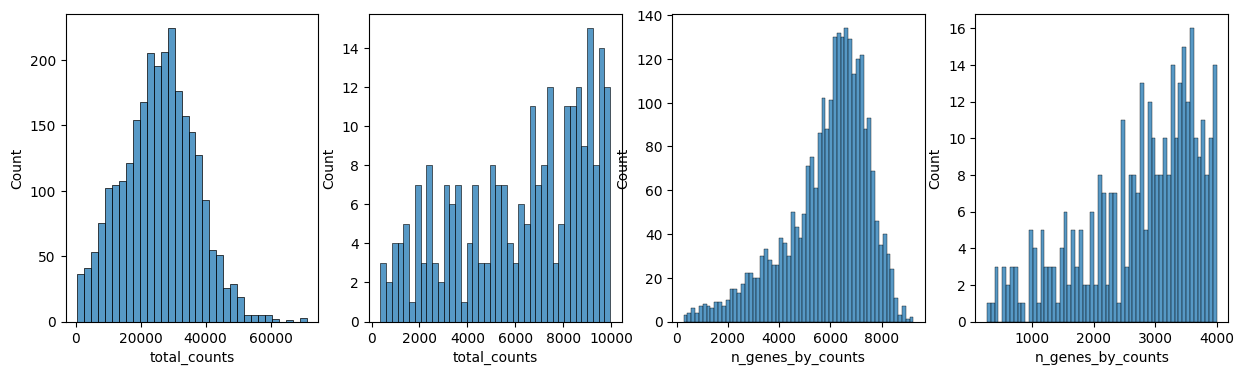

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.histplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])

In [8]:
sc.pp.filter_cells(adata, max_counts=50000)
adata = adata[adata.obs.pct_counts_mt < 20]
sc.pp.filter_genes(adata, min_cells=10)

/Users/harald/Documents/opt/scllm/.venv/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:287: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


In [9]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000, subset=True)

/var/folders/_4/qhxlw4x53134ffft2v5pt3nh0000gn/T/ipykernel_12604/3976244732.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts"])


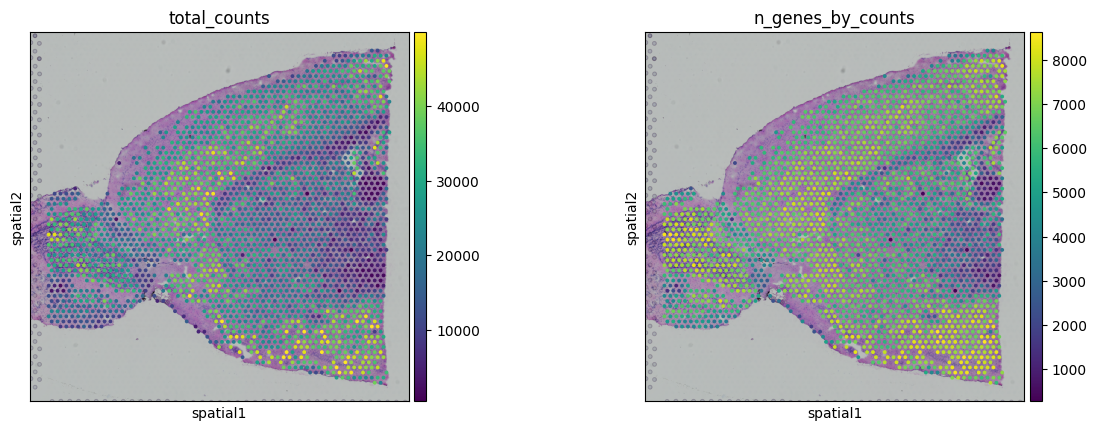

In [10]:
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts"])

In [11]:
nmf = NMF(n_components=10, max_iter=1000)

In [12]:
Z = nmf.fit_transform(adata.X.toarray())
W = nmf.components_

In [13]:
adata.obsm['X_nmf'] = Z
adata.varm['NMF'] = W.T
adata.obs = pd.concat([adata.obs, pd.DataFrame(Z, index=adata.obs.index, columns=[f'NMF{i}' for i in range(10)])], axis=1)

In [14]:
adata

AnnData object with n_obs × n_vars = 2448 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'NMF0', 'NMF1', 'NMF2', 'NMF3', 'NMF4', 'NMF5', 'NMF6', 'NMF7', 'NMF8', 'NMF9'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg'
    obsm: 'spatial', 'X_nmf'
    varm: 'NMF'

/var/folders/_4/qhxlw4x53134ffft2v5pt3nh0000gn/T/ipykernel_12133/4223846374.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, img_key="hires", color=["NMF0", "NMF1", "NMF2", "NMF3", "NMF4", "NMF5", "NMF6", "NMF7", "NMF8", "NMF9"])


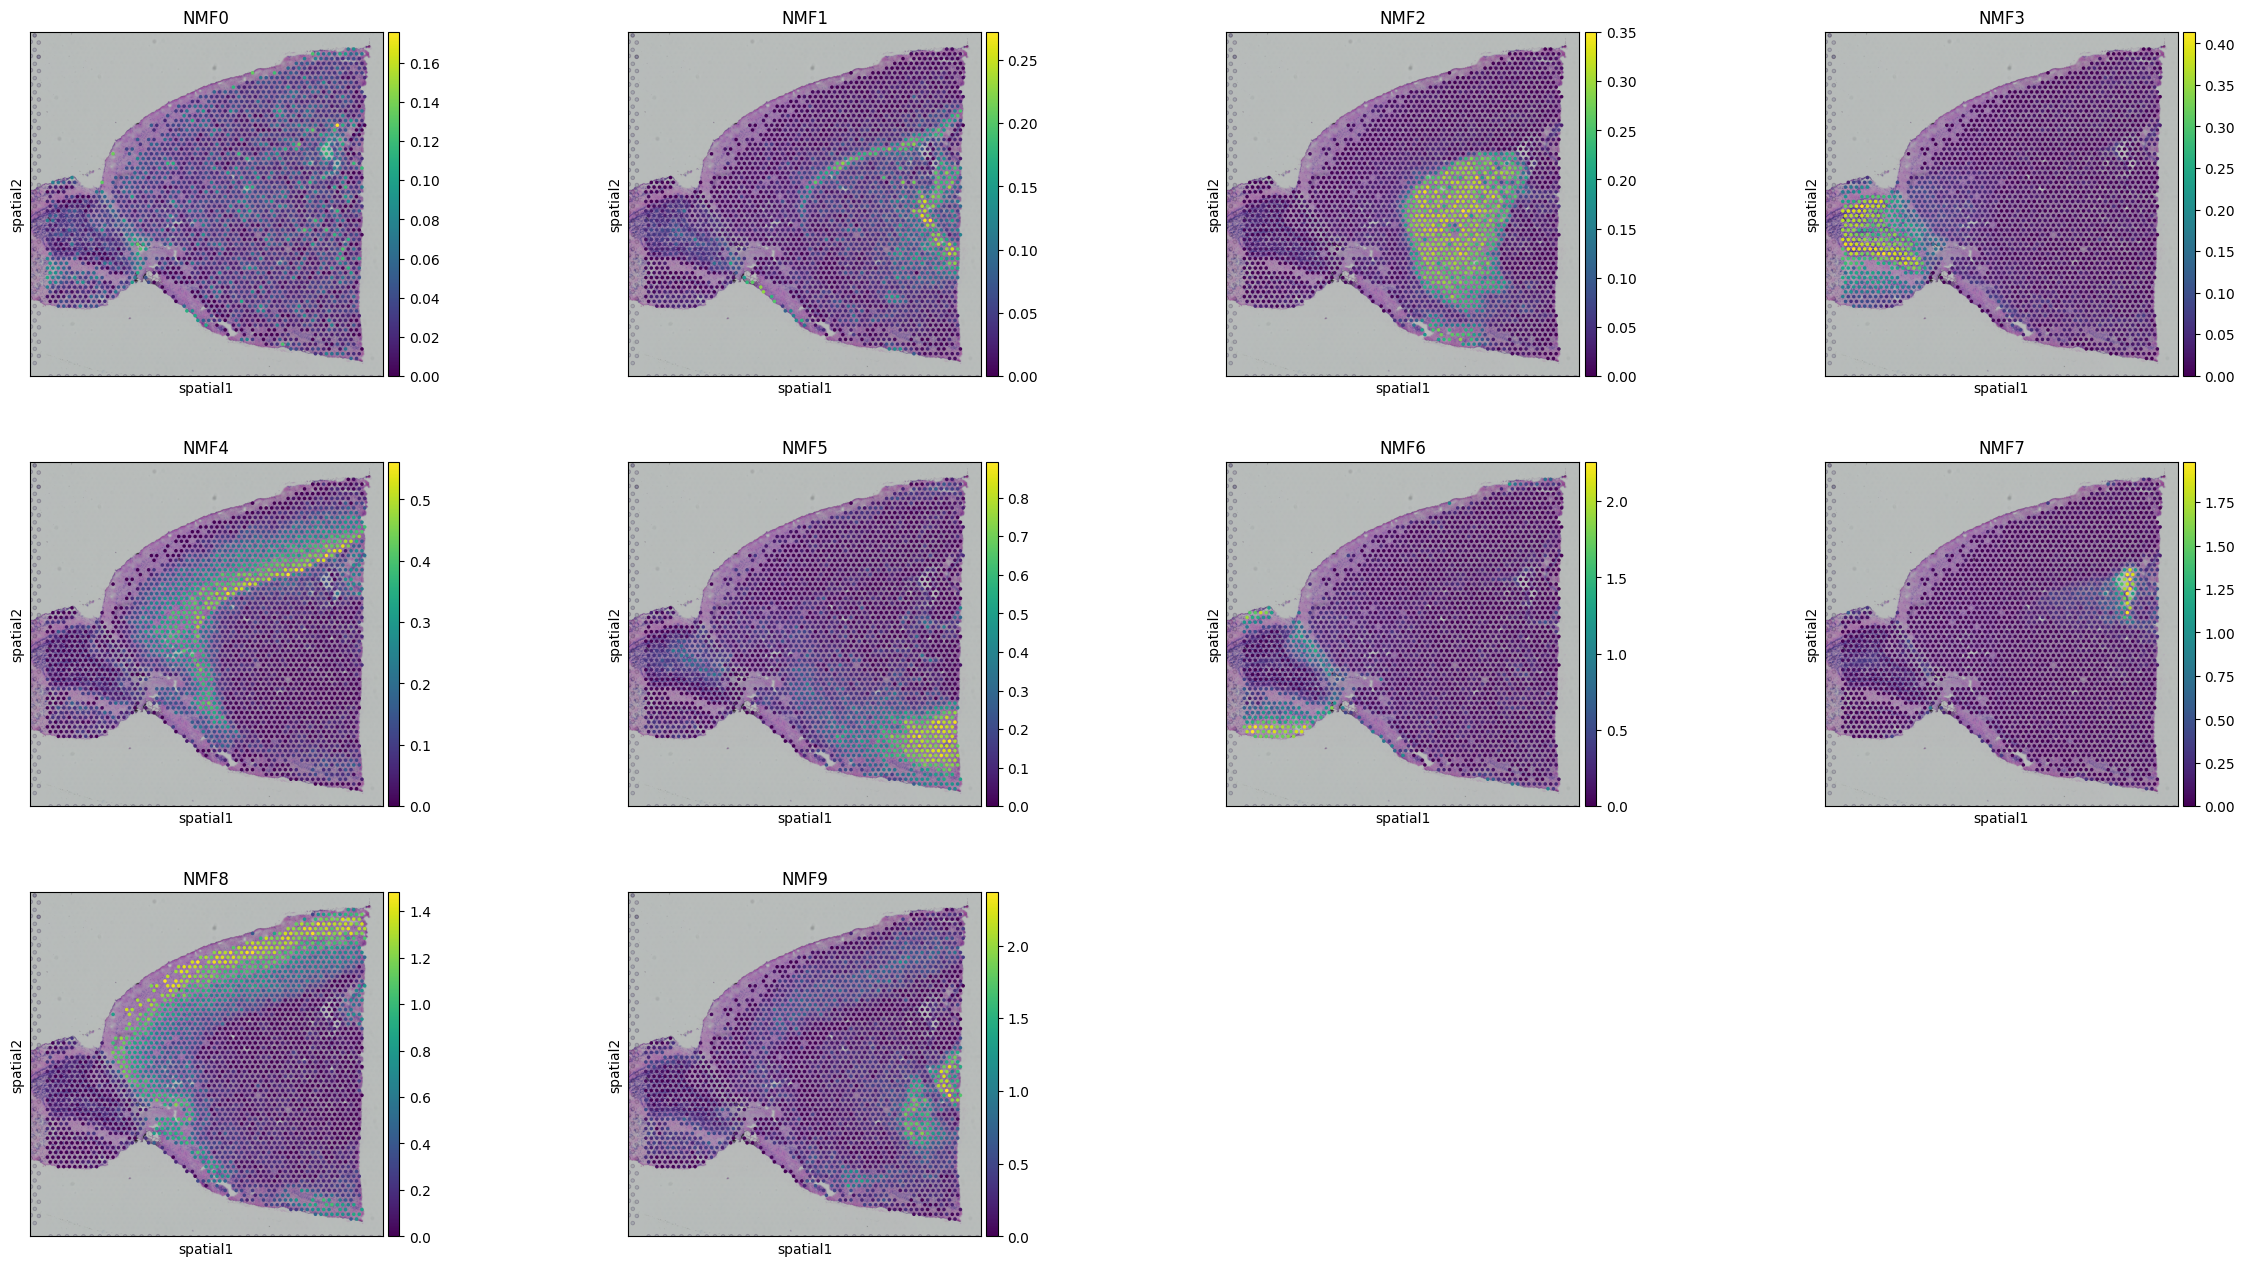

In [15]:
sc.pl.spatial(adata, img_key="hires", color=["NMF0", "NMF1", "NMF2", "NMF3", "NMF4", "NMF5", "NMF6", "NMF7", "NMF8", "NMF9"])

In [15]:
sl.tl.annotate_factor(
    adata,
    varm_key="NMF",
    llm=llm,
    sign="+"
)

In [16]:
adata.uns['factor_annotation']['mapping']

{'0+': 'Erythrocyte',
 '1+': 'Oligodendrocyte',
 '2+': 'Medium Spiny Neuron',
 '3+': 'Purkinje neuron',
 '4+': 'Excitatory Neuron',
 '5+': 'Neuroendocrine Cell',
 '6+': 'Astrocyte',
 '7+': 'Hepatocyte',
 '8+': 'Excitatory Neuron',
 '9+': 'Inhibitory Interneuron'}

In [17]:
adata

AnnData object with n_obs × n_vars = 2448 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'NMF0', 'NMF1', 'NMF2', 'NMF3', 'NMF4', 'NMF5', 'NMF6', 'NMF7', 'NMF8', 'NMF9'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg', 'factor_annotation'
    obsm: 'spatial', 'X_nmf'
    varm: 'NMF'

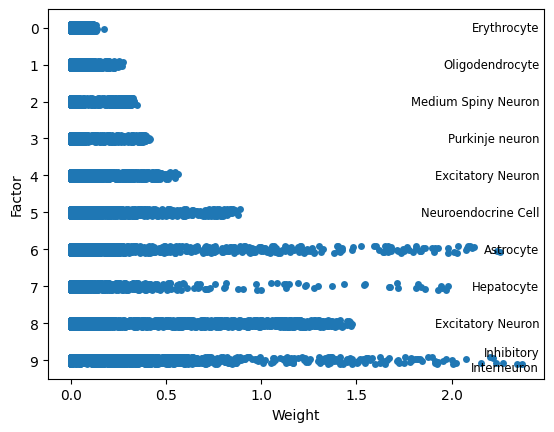

In [18]:
sl.pl.factor_stripplot(
    adata,
    obsm_key="X_nmf",
    annotation_key="factor_annotation"
)

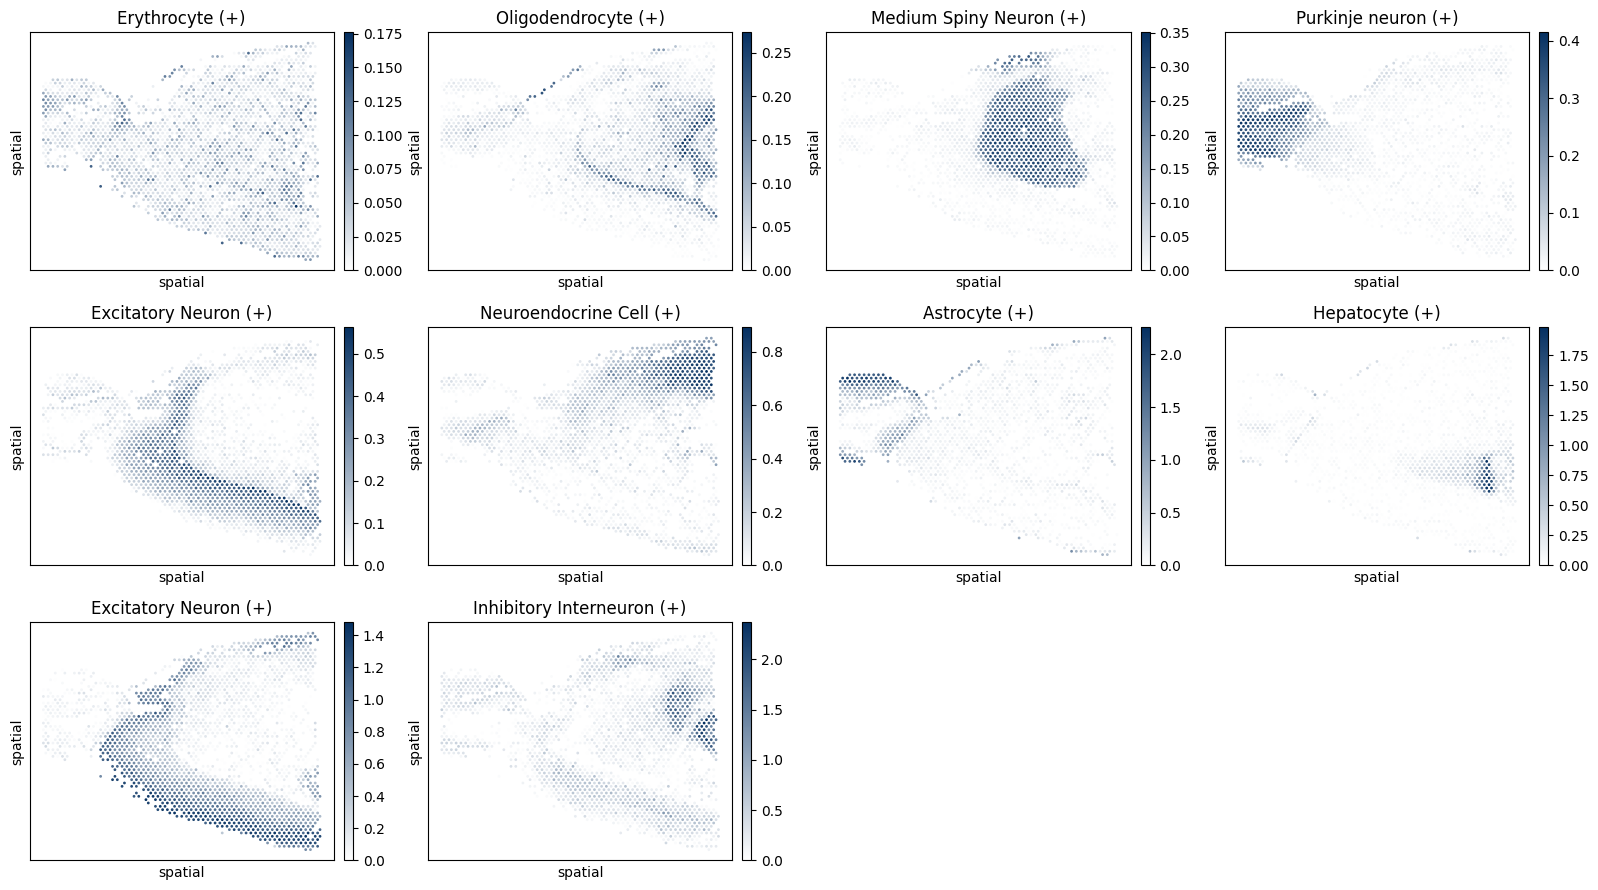

In [27]:
_ = sl.pl.factor_embedding(
    adata, 
    obsm_key="X_nmf",
    basis='spatial',
    annotation_key="factor_annotation"
)
plt.tight_layout()